In [1]:
import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[1])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)
from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import L1WaveletRecon


## My files
import save_data_helpers
import recon_functions
import recon_plot_helpers

### 1. Load data

In [2]:
idx_amp_all, resp_trimmed_amp_all, data_bins_amp_all, spoke_bins_amp_all, index_bins_amp_all = save_data_helpers.load_gate_outputs_pickle('/home/lilianae/projects/naf_clean/load_data_clean/subject2_mid0082/gates_amp_all_slices.pkl')

Loaded /home/lilianae/projects/naf_clean/load_data_clean/subject2_mid0082/gates_amp_all_slices.pkl
  idx shape: (113116,)
  signal_trimmed shape: (113116,)
  data_bins: 5 elements
  spoke_bins: 5 elements
  index_bins: 5 elements


In [3]:
print(f'data_bins_amp_all[0].shape = {data_bins_amp_all[0].shape}')

data_bins_amp_all[0].shape = (15, 22623, 256)


In [4]:
ncoils, nslices, nspokes, nsamples = (15, 58, 2002, 256)
img_shape = (nslices,nsamples,nsamples)

### 2. Create Fs operator

Fake coil sens

In [5]:
# Coil sensitivity
mps_shape = (ncoils, *img_shape)
mps = np.ones(mps_shape, dtype=np.complex64)

In [6]:
print('Reconstruction:')

# setup spoke coordinate data and kspace data:
device=0

## Multiply and NUFFT operator
num_coils = len(mps)
ishape = (58, 256, 256)
S = sp.linop.Multiply(ishape, mps)

print(f'S.oshape = {S.oshape}')

F = sp.linop.NUFFT(S.oshape, coord=spoke_bins_amp_all[0])
A = F * S
A.repr_str = 'Sense'

print(f'A = {A}')

Fs = A ## is this right
max_eig_op = sp.app.MaxEig(Fs.H * Fs, dtype=cp.complex64, device=device,max_iter=30).run()  
Fs = (1/np.sqrt(max_eig_op))*Fs
print(f'Fs = {Fs}')

Reconstruction:
S.oshape = [15, 58, 256, 256]
A = <[15, 22623, 256]x[58, 256, 256]> Sense Linop>


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

Fs = <[15, 22623, 256]x[58, 256, 256]> Multiply * Sense Linop>


In [7]:
def create_wavelet_transform(lamda, wave_name, max_iter=30):
    
    W = sp.linop.Wavelet(img_shape, wave_name=wave_name)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)

    def g(input):
        device = sp.get_device(input)
        xp = device.xp
        with device:
            return lamda * xp.sum(xp.abs(W(input))).item() 
    
    return proxg, g 

In [8]:
# gradient op for TV:
device=0

## L1 Wavelet preparation
lams = [1e-07, 1e-09, 1e-10]

num_gates_to_reconstruct = 1 
output = np.zeros((*img_shape, num_gates_to_reconstruct, len(lams)))


with cp.cuda.Device(device=0):
    for gate_idx in range(num_gates_to_reconstruct):
        for j,lam in enumerate(lams):
            max_iter=30
            wave_name='db4'
            proxg, g = create_wavelet_transform(lamda=lam, wave_name=wave_name, max_iter=max_iter)

            alg02 = sp.app.LinearLeastSquares(Fs,
                                    sp.to_device(data_bins_amp_all[gate_idx],device),
                                    proxg=proxg, g=g, 
                                    max_iter=max_iter)

            result=alg02.run()
            output[...,gate_idx, j]=np.abs(cp.asnumpy(result))

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/30 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/30 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# save_data_helpers.write_pickle(output, "test_l1_amp_all_manual_2.pkl")

Successfully saved as test_l1_amp_all_manual_2.pkl


In [13]:
output = save_data_helpers.read_pickle("test_l1_amp_all_manual.pkl")

In [14]:
print(output.shape)

(58, 256, 256, 1, 3)


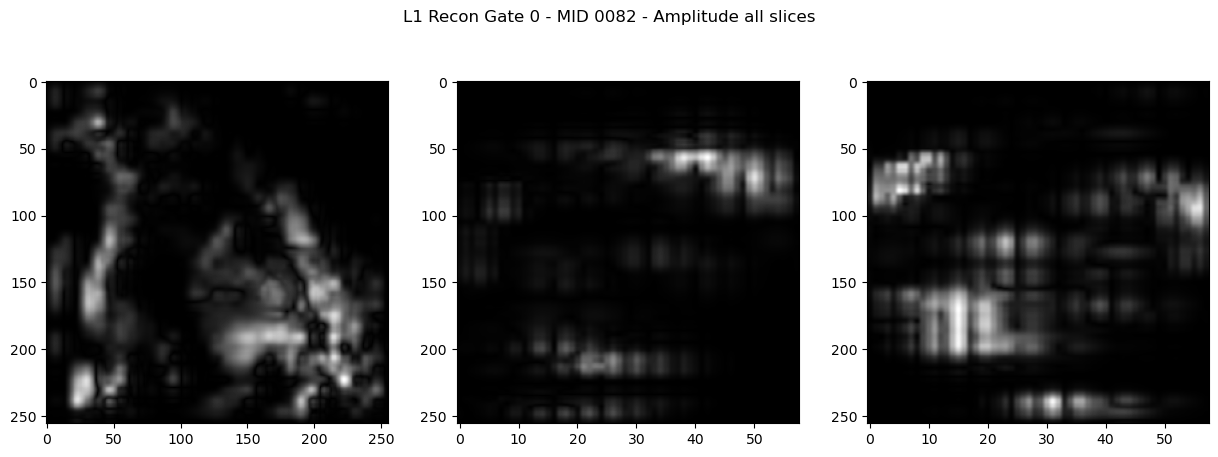

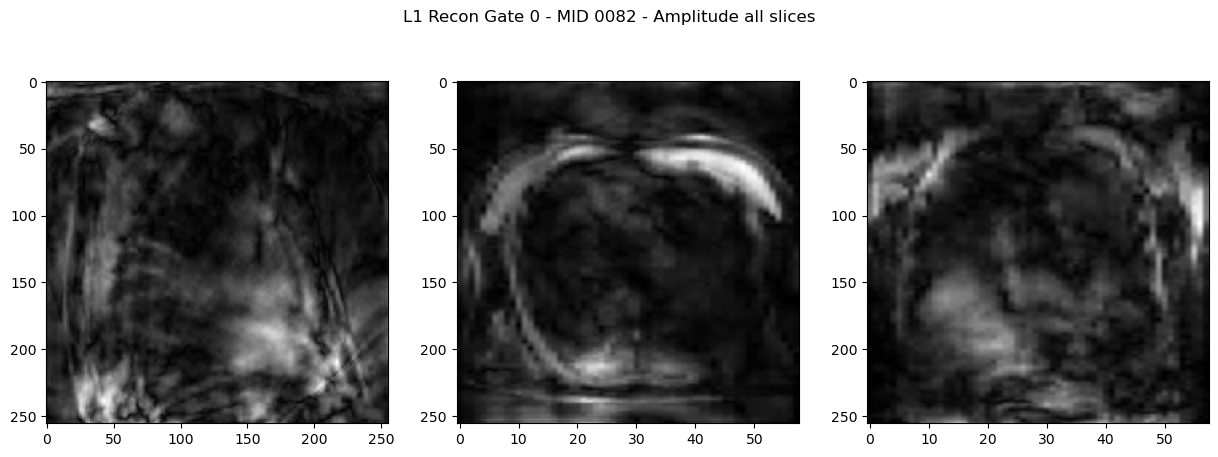

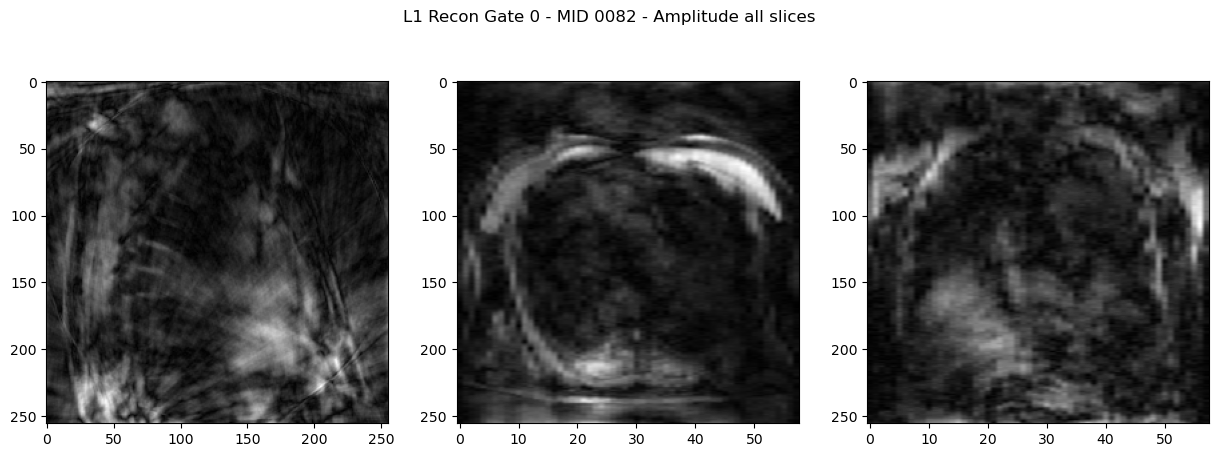

In [15]:
for j in range(len(lams)):
    fig, axs = recon_plot_helpers.plot_recons_all_axes(output[...,0,j], title=f'L1 Recon Gate 0 - MID 0082 - Amplitude all slices')